# **Introducción**

Este notebook de Jupyter contiene las soluciones propuestas a los apartados del enunciado de la práctica 1. Incluye tanto la implementación de los clasificadores como las pruebas realizadas con estos. A continuación se explica el procedimiento seguido para implementar cada clasificador:

**Clasificador distancia euclídea:**
El entrenamiento de este clasificador consiste en calcular los centroides $z_{i}$ de cada clase:

$$z_{i} = \frac{1}{card(\alpha_{i})}\sum\limits _{∀x\in\alpha_{i}}x $$

La predicción consiste en calcular la distancia euclídea de cada vector de entrada a los centroides de cada clase y elegir la clase que se corresponde con la menor distancia euclídea asociada. La función de pertenencia es la siguiente:

$$ de_{i}(x) ≡ D_{E}(x, z_{i}) = \sqrt{\sum\limits_{j=0}^{n}(x_{j}-z_{i})^{2}}$$

Donde $D_{E}(x, z_{i})$ es la distancia eculídea de $x$ al centroide $z_{i}$ y $j$ es la dimensión de cada dato. Dado que esta función proporciona la distancia a una clase, se selecciona el valor mínimo. Se asigna el elemento $x$ a la clase $α_{i}$ si:

$$ i = \arg_{\min_{j}}\{de_{i}(x)\} $$

**Clasificador estadístico bayesiano:** Este clasificador parte de la hipótesis de distribución gaussiana. La función de pertenencia del clasificador es la siguiente:

$$ db_{i}(x) = -\frac{1}{2}ln(|\Sigma_{i}|)-\frac{1}{2}(x-\mu_{i})^{T}\Sigma_{i}^{-1}(x-\mu_{i})+\ln P(\alpha_{i})$$

Donde $\Sigma_{i}$ es la matriz de covarianza de la clase $\alpha_{i}$, $P(\alpha_{i})$ es la probabilidad a priori de la clase $\alpha_{i}$, y $\mu_{i}$ es la media de la clase $\alpha_{i}$. Dado que esta función proporciona una probabilidad de pertenencia a una clase, se selecciona el valor máximo. Se asigna el elemento $x$ a la clase $\alpha_{i}$ si:

$$ i = \arg_{\max_{j}}\{db_{i}(x)\} $$

En la implementación se emplea $dbq_{i} = \ln(db_{i}(x))$, que tiene forma cuadrática:

$$ dbq_{i}(x) = x^{T}[-\frac{1}{2}\Sigma_{i}^{-1}]x + [\mu_{i}^{T}\Sigma_{i}^{-1}]x -\frac{1}{2}\mu_{i}^{T}\Sigma_{i}^{-1}\mu_{i} -\frac{1}{2}\ln|\Sigma_{i}| + \ln P(\alpha_{i})$$

En la implementación, los términos $a$, $b$ y $c$ de la expresión cuadrática $ax^{2}+bx+c$ se corresponden con:

$$a = -\frac{1}{2}\Sigma_{i}^{-1}$$

$$b = \mu_{i}^{T}\Sigma_{i}^{-1}$$

$$c = -\frac{1}{2}\mu_{i}^{T}\Sigma_{i}^{-1}\mu_{i} -\frac{1}{2}\ln|\Sigma_{i}| + \ln P(\alpha_{i})$$

Estos términos se calculan en el entrenamiento del clasificador, dado que son independientes del vector $x$ de entrada. En la función clasificadora, se calcula $dbq_{i}(x)$.

El clasificador regularizado añade dos hiperparámetros en el cálculo de $db_{i}(x)$: $\lambda$ y $\gamma$. El primero indica una medida de similitud entre clases, mientras que el segundo sirve para regularizar la matrix de covarianzas. Primero se calcula la matrix $\Sigma_{i}^{\lambda}$:

$$\Sigma_{i}^{\lambda} = \frac{(1-\lambda)n_{i}\Sigma_{i} + \lambda nS_{w}}{(1-\lambda)n_{i} + \lambda n}$$

Donde $n_{i}$ es el número de representantes de la clase $i$, $n$ es el número total de representantes, y $S_{w}$ es la matriz

$$S_{w} = \sum\limits_{i=0}^{n_{c}}\frac{n_{i}}{n}\Sigma_{i}$$

donde $n_{c}$ es el número de clases.

A continuación se calcula la matriz $\Sigma_{i}^{\lambda, \gamma}$:

$$\Sigma_{i}^{\lambda, \gamma} = (1-\lambda)\Sigma_{i}^{\lambda} + \gamma c_{i} I_{d}$$

Donde $I_{d}$ es la matriz identidad $d x d$, $d$ la dimensión de cada representante y $c_{i}$ es:

$$c_{i} = \frac{Tr\{\Sigma_{i}^{\lambda}\}}{d}$$

Con la nueva matrix de covarianzas $\Sigma_{i}^{\lambda, \gamma}$ se calcula $dbrq_{i}(x)$: 

$$ dbrq_{i}(x) = x^{T}[-\frac{1}{2}\Sigma_{i}^{\lambda, \gamma -1}]x + [\mu_{i}^{T}\Sigma_{i}^{\lambda, \gamma -1}]x -\frac{1}{2}\mu_{i}^{T}\Sigma_{i}^{\lambda, \gamma -1}\mu_{i} -\frac{1}{2}\ln|\Sigma_{i}^{\lambda, \gamma}| + \ln P(\alpha_{i})$$

**NOTA**: Se incluyen las implemetanciones de los siguientes clasificadores:
* **Clasificador de la distancia euclídea**: implementado con la función $de_{i}(x)$. Está disponible en la clase *ClassifEuclid.*
* **Clasificador estadístico sin regularizar:** implementado con la función $dbq_{i}(x)$. Está disponible en la clase *ClassifEstadistico*
* **Clasificador estadístico regularizado:** implementado con la función $dbrq_{i}(x)$. Está disponible en la clase *ClassifEstadisticoRegularizado_metodo_clase*
* **Clasificador estadístico regularizado (método de sklearn):** implementado con regularización por autovectores. Está disponible en la clase *ClassifEstadisticoRegularizado_metodo_sklearn*


# **Implementación de clasificadores**

In [56]:
import numpy as np
from abc import abstractmethod
from sklearn.base import BaseEstimator

class Classifier(BaseEstimator):

    @abstractmethod
    def fit(self, X, y):
        pass

    @abstractmethod
    def decision_function(self, X):
        pass
    
    @abstractmethod
    def predict(self, X):
        pass
    
    def score(self, X, y):
        return self.num_aciertos(X, y) / len(y)


#### **Clasificador de la distancia euclídea**

In [3]:
class ClassifEuclid(Classifier, BaseEstimator):
    
    def __init__(self, labels=[]):
        """Constructor de la clase
        labels: lista de etiquetas de esta clase (argumento necesario)"""
        self.labels = labels
        self.Z = None # Array de centroides

    def fit(self, X, y):
        """Entrena el clasificador
        X: matriz numpy cada fila es un dato, cada columna una medida
        y: vector de etiquetas, tantos elementos como filas en X
        retorna objeto clasificador"""
        n = np.zeros(len(self.labels)) # Contador de ocurrencias de cada clase
        self.Z = np.zeros((len(self.labels), X.shape[1]))
        # Calcular la media: 
        # Sumar las ocurrencias de cada clase en self.Z
        for yi, Xi in zip(y, X):
            n[yi] = n[yi] + 1
            self.Z[yi] = self.Z[yi] + Xi
        # Dividir cada sumatorio entre el númeo de ocurrencias
        self.Z = self.Z / n[:, None]
        return self

    def decision_function(self, X):
        """Estima el grado de pertenencia de cada dato a todas las clases 
        X: matriz numpy cada fila es un dato, cada columna una medida del vector de caracteristicas. 
        Retorna una matriz, con tantas filas como datos y tantas columnas como clases tenga
        el problema, cada fila almacena los valores pertenencia de un dato a cada clase"""
        # Calcular la distancia de cada fila a cada centroide
        aux = X[:,None]-self.Z
        return np.sqrt(np.einsum('abc,abc->ab', aux, aux))

    def predict(self, X):
        """Estima la etiqueta de cada dato. La etiqueta puede ser un entero o bien un string.
        X: matriz numpy cada fila es un dato, cada columna una medida
        retorna un vector con las etiquetas de cada dato"""
        # Devuelve un array con el índice con valor mínimo de cada fila.
        # Cada índice se corresponde con la clase a la que pertenece.
        return np.argmin(self.decision_function(X), axis=1)
    
    def num_aciertos(self, X, y):
        """Cuenta el numero de aciertos del clasificador para un conjunto de datos X.
        X: matriz de datos a clasificar
        y: vector de etiquetas correctas"""
        # Contar el número de datos iguales en ambos vectores
        return np.sum(self.predict(X)==y)


#### **Clasificador estadístico bayesiano**

In [4]:
class ClassifEstadistico(Classifier, BaseEstimator):
    
    def __init__(self, labels=[]):
        """Constructor de la clase
        labels: lista de etiquetas de esta clase (argumento necesario)"""
        self.labels = labels
        self.mu = None # Array de medias
        self.cov = None # Array de matrices de covarianza de cada clase
        self.cov_inv = None # Array de matrices de covarianza inversas
        self.det = None # Array de determinantes de las matrices de covarianza
        # Terminos de la expresión cuadrática del clasificador
        self.a = None
        self.b = None
        self.c = None

    def fit(self,X,y):
        """Entrena el clasificador
        X: matriz numpy cada fila es un dato, cada columna una medida
        y: vector de etiquetas, tantos elementos como filas en X
        retorna objeto clasificador"""
        n_labels = len(self.labels)
        n_caracteristicas = X.shape[1]
        self.mu = np.empty((n_labels, n_caracteristicas))
        self.cov = np.empty((n_labels, n_caracteristicas, n_caracteristicas))
        self.cov_inv = np.empty((n_labels, n_caracteristicas, n_caracteristicas))
        self.det = np.empty(n_labels)
        self.a = np.empty((n_labels, n_caracteristicas, n_caracteristicas))
        self.b = np.empty((n_labels, n_caracteristicas))
        self.c = np.empty(n_labels)
        for c in range(len(self.labels)):
            self.cov[c] = np.cov(X[y==c], rowvar=False)
            self.mu[c] = np.mean(X[y==c], axis=0)
            self.cov_inv[c] = np.linalg.inv(self.cov[c])
            self.det[c] = np.linalg.det(self.cov[c])
            self.a[c] = -.5 * self.cov_inv[c]
            self.b[c] = self.mu[c].T @ self.cov_inv[c]
            self.c[c] = -.5 * (self.mu[c].T @ self.cov_inv[c] @ self.mu[c]) -.5 * np.log(self.det[c]) + np.log(np.sum(y==c)/X.shape[0])
        return self

    def decision_function(self,X):
        """Estima el grado de pertenencia de cada dato a todas las clases 
        X: matriz numpy cada fila es un dato, cada columna una medida del vector de caracteristicas. 
        Retorna una matriz, con tantas filas como datos y tantas columnas como clases tenga
        el problema, cada fila almacena los valores pertenencia de un dato a cada clase"""
        return np.einsum('ab,cdb,ad->ac', X, self.a, X) + np.einsum('ab,cb->ca', self.b, X) + self.c[None,:]

    def predict(self,X):
        """Estima la etiqueta de cada dato. La etiqueta puede ser un entero o bien un string.
        X: matriz numpy cada fila es un dato, cada columna una medida
        retorna un vector con las etiquetas de cada dato"""
        return np.argmax(self.decision_function(X), axis=1)
    
    def num_aciertos(self,X,y):
        """Cuenta el numero de aciertos del clasificador para un conjunto de datos X.
        X: matriz de datos a clasificar
        y: vector de etiquetas correctas"""
        return np.sum(self.predict(X)==y)


#### **Clasificador estadístico bayesiano regularizado (método visto en clase, explicado en la introducción)**

In [228]:
class ClassifEstadisticoRegularizado_metodo_clase(Classifier, BaseEstimator):
    
    def __init__(self, labels=[]):
        """Constructor de la clase
        labels: lista de etiquetas de esta clase (argumento necesario)"""
        self.labels = labels
        self.mu = None # Array de medias
        self.cov = None # Array de matrices de covarianza de cada clase
        self.cov_reg = None # Array de matrices de covarianza regularizadas
        self.cov_reg_inv = None # Array de matrices de covarianza inversas
        self.det = None # Array de determinantes de las matrices de covarianza
        self.dont_ignore = [] # dimensiones a NO ignorar si cov se puede invertir
        self.priori = None

    def fit(self, X, y, l=0, g=0):
        """Entrena el clasificador
        X: matriz numpy cada fila es un dato, cada columna una medida
        y: vector de etiquetas, tantos elementos como filas en X
        l: hiperparámetro de similitud entre matrices de covarianza
        g: hiperparámetro de regularización
        retorna objeto clasificador"""
        n_labels = len(self.labels)
        n_caracteristicas = X.shape[1]
        self.mu = np.empty((n_labels, n_caracteristicas))
        self.cov = np.empty((n_labels, n_caracteristicas, n_caracteristicas))
        self.cov_lg = np.empty((n_labels, n_caracteristicas, n_caracteristicas))
        self.cov_lg_inv = np.empty((n_labels, n_caracteristicas, n_caracteristicas))
        self.det = np.empty(n_labels)
        self.priori = np.empty(n_labels)
        cov_pooled = np.zeros((n_caracteristicas, n_caracteristicas))
        for c in range(len(self.labels)):
            X_clase = X[y==c]
            self.cov[c] = np.cov(X_clase, rowvar=False)
            cov_pooled = cov_pooled + ((X_clase.shape[0] / X.shape[0]) * self.cov[c])  # Matriz Sw en el libro de Webb (formula 2.15, pagina 42)
        for c in range(len(self.labels)):
            X_clase = X[y==c]
            self.mu[c] = np.mean(X_clase, axis=0)
            cov_l = (((1 - l) * X_clase.shape[0] * self.cov[c]) + (l * X.shape[0] * cov_pooled)) / ((1 - l) * X_clase.shape[0] + l * X.shape[0])
            self.cov_lg[c] = (1 - g) * cov_l + g * (np.trace(cov_l) / n_caracteristicas) * np.eye(n_caracteristicas)
            self.det[c] = np.linalg.det(self.cov_lg[c])
            if self.det[c] != 0:
                self.cov_lg_inv[c] = np.linalg.inv(self.cov_lg[c])
                self.det[c] = np.linalg.det(self.cov_lg[c])
                self.priori = X_clase.shape[0] / X.shape[0]
                self.dont_ignore.append(c)
        return self

    def decision_function(self,X):
        """Estima el grado de pertenencia de cada dato a todas las clases 
        X: matriz numpy cada fila es un dato, cada columna una medida del vector de caracteristicas. 
        Retorna una matriz, con tantas filas como datos y tantas columnas como clases tenga
        el problema, cada fila almacena los valores pertenencia de un dato a cada clase"""
        res = np.zeros((X.shape[0], len(self.labels)))
        for c in self.dont_ignore:
            res[:,c] = -.5 * np.log(self.det[c]) - .5 * np.diagonal((X - self.mu[c]) @ self.cov_lg_inv[c] @ (X - self.mu[c]).T) + np.log(self.priori)
        return res
        #return np.einsum('ab,cdb,ad->ac', X, self.a, X) + np.einsum('ab,cb->ca', self.b, X) + self.c[None,:]

    def predict(self,X):
        """Estima la etiqueta de cada dato. La etiqueta puede ser un entero o bien un string.
        X: matriz numpy cada fila es un dato, cada columna una medida
        retorna un vector con las etiquetas de cada dato"""
        return np.argmax(self.decision_function(X), axis=1)
    
    def num_aciertos(self,X,y):
        """Cuenta el numero de aciertos del clasificador para un conjunto de datos X.
        X: matriz de datos a clasificar
        y: vector de etiquetas correctas"""
        return np.sum(self.predict(X)==y)


#### **Clasificador estadístico bayesiano regularizado por autovectores (método de sklearn)**

In [159]:
class ClassifEstadisticoRegularizado_metodo_sklearn(Classifier, BaseEstimator):
    
    def __init__(self, labels=[]):
        self.labels = labels
        self.reg_param = 0 # hiperparametro
        self.mu = None # Array de medias
        self.cov = None # Array de matrices de covarianza de cada clase
        self.prob_clases = None
        self.ajustes = []
        self.autovectores = []

    def fit(self, X, y, reg_param=0):
        self.reg_param = reg_param
        n_labels = len(self.labels)
        n_caracteristicas = X.shape[1]
        self.mu = np.empty((n_labels, n_caracteristicas))
        self.cov = np.empty((n_labels, n_caracteristicas, n_caracteristicas))
        self.prob_clases = np.empty(n_labels)
        for c in range(len(self.labels)):
            X_clase = X[y==c, :]
            self.mu[c] = np.mean(X_clase, axis=0)
            X_new = X_clase - self.mu[c]
            # descomposicion espectral
            _, autovalores, autovectores = np.linalg.svd(X_new, full_matrices=False)
            ajuste = (autovalores ** 2) / (X_new.shape[0] - 1)
            ajuste = ((1 - self.reg_param) * ajuste) + self.reg_param
            self.cov[c] = (ajuste * autovectores.T) @ autovectores # np.dot(ajuste * autovectores.T, autovectores)
            self.ajustes.append(np.copy(ajuste))
            self.autovectores.append(np.copy(autovectores))
            self.prob_clases[c] = X_clase.shape[0] / X.shape[0]
        return self

    def decision_function(self,X):
        """Estima el grado de pertenencia de cada dato a todas las clases 
        X: matriz numpy cada fila es un dato, cada columna una medida del vector de caracteristicas. 
        Retorna una matriz, con tantas filas como datos y tantas columnas como clases tenga
        el problema, cada fila almacena los valores pertenencia de un dato a cada clase"""
        res = np.empty((X.shape[0], len(self.labels)))
        for c in range(len(self.labels)):
            res[:,c] = np.sum(((X - self.mu[c]) @ (self.autovectores[c] * (self.ajustes[c] ** -.5)[:, None]).T) ** 2, axis=1)
        aux = np.asarray([np.sum(np.log(x)) for x in self.ajustes])
        return (-.5 * (res.T + aux[:, None]) + np.log(self.prob_clases)[:, None]).T
    
    def predict(self,X):
        """Estima la etiqueta de cada dato. La etiqueta puede ser un entero o bien un string.
        X: matriz numpy cada fila es un dato, cada columna una medida
        retorna un vector con las etiquetas de cada dato"""
        return np.argmax(self.decision_function(X), axis=1)
    
    def num_aciertos(self,X,y):
        """Cuenta el numero de aciertos del clasificador para un conjunto de datos X.
        X: matriz de datos a clasificar
        y: vector de etiquetas correctas"""
        return np.sum(self.predict(X)==y)


#### **Clase Splitter para GridSearchCV**

In [85]:
class ExclusionSplitter:
    """Esta clase nos permite usar GridSearchCV con la valuación por exclusion."""
    def __init__(self, train_indices, test_indices):
        self.train_indices = train_indices
        self.test_indices = test_indices

    def split(self, X, y=None, groups=None):
        return [(self.train_indices, self.test_indices)]

    def get_n_splits(self, X=None, y=None, groups=None):
        return 1


#### **Implemetación de Cross Validation con KFolds**
Esta implementación funciona, pero no debe usarse. No siempre ofrece los mismos resultados porque el array de entrada se baraja de forma aleatoria.

In [60]:
def cv_score(clsf, X, y, cv):
    permutation = np.random.permutation(X.shape[0])
    X_chunks = np.array_split(X[permutation], cv)
    y_chunks = np.array_split(y[permutation], cv)
    scores = np.empty(cv)
    for i in range(cv):
        X_test = X_chunks[i]
        y_test = y_chunks[i]
        X_train_chunks = X_chunks[:i] + X_chunks[i+1:]
        y_train_chunks = y_chunks[:i] + y_chunks[i+1:]
        X_train = np.vstack(X_train_chunks)
        y_train = np.hstack(y_train_chunks)
        clsf.fit(X_train, y_train)
        scores[i] = clsf.score(X_test, y_test)
    return scores


#### **Implemetación de Cross Validation con Stratified KFolds**
Esta implementación funciona, pero no debe usarse. No es una implementación eficiente.

In [61]:
from sklearn.model_selection import StratifiedKFold
def cv_score_skf(clsf, X, y, cv, reg_param=0):
    skf = StratifiedKFold(n_splits=cv)
    i = 0
    for train_i, test_i in skf.split(X, y):
        X_train = X[train_i]
        y_train = y[train_i]
        X_test = X[test_i]
        y_test = y[test_i]
        clsf.fit(X_train, y_train, reg_param)
        scores[i] = clsf.score(X_test, y_test)
        i = i + 1
    return scores


# **Entrenamiento, predicción y evaluación de iris, wine y cancer**
A continuación se realizan las pruebas correspondientes con las bases de datos iris, wine y cancer con el clasificador estadístico y el clasificador de la distancia euclídea. Al final se incluye una tabla resumen con los resultados. Por cada clasificador y base de datos se imprime el resultado obtenido por el clasificador equivalente de sklearn, con el fin de verificar los resultados.

In [77]:
from sklearn.datasets import load_iris, load_wine, load_breast_cancer
from sklearn.neighbors import NearestCentroid
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
# Load data
dataset_iris = load_iris()
X_iris = dataset_iris.data
y_iris = dataset_iris.target
dataset_wine = load_wine()
X_wine = dataset_wine.data
y_wine = dataset_wine.target
dataset_cancer = load_breast_cancer()
X_cancer = dataset_cancer.data
y_cancer = dataset_cancer.target
print("iris: datos:", X_iris.shape, "n_clases:", len(np.unique(y_iris)))
print("wine: datos:", X_wine.shape, "n_clases:", len(np.unique(y_wine)))
print("cancer: datos:", X_cancer.shape, "n_clases:", len(np.unique(y_cancer)))

iris: datos: (150, 4) n_clases: 3
wine: datos: (178, 13) n_clases: 3
cancer: datos: (569, 30) n_clases: 2


#### **Clasificador de la distancia euclídea**

##### Base de datos **iris**

In [78]:
# Nuestro clasificador
clsf_euc = ClassifEuclid(dataset_iris.target_names)
clsf_euc.fit(np.array(X_iris), y_iris)
n_aciertos = clsf_euc.num_aciertos(X_iris, y_iris)
print("\tiris:   Aciertos: ", n_aciertos, "/", len(y_iris), " (", "%.2f" % ((n_aciertos / len(y_iris))*100), "%)", sep='')
# Evaluación por resustitución y validación cruzada
print("\t\tEvaluación por resustitución:", "%.4f" % clsf_euc.score(X_iris, y_iris))
scores = cross_val_score(clsf_euc, X_iris, y_iris, cv=5)
#scores = cv_score(clsf_euc, X_iris, y_iris, cv=5)
print("\t\tEvaluación por validación cruzada: ", "%.4f" % np.mean(scores), ", std: ", "%.4f" % np.std(scores), sep='')
# Comparación con el clasificador de sklearn
nc = NearestCentroid().fit(X_iris, y_iris)
print("\t\t", "Clasificador sklearn: ", np.sum(nc.predict(X_iris)==y_iris), " aciertos", sep='')

	iris:   Aciertos: 139/150 (92.67%)
		Evaluación por resustitución: 0.9267
		Evaluación por validación cruzada: 0.9133, std: 0.0499
		Clasificador sklearn: 139 aciertos


##### Base de datos **wine**

In [65]:
# Nuestro clasificador
clsf_euc = ClassifEuclid(dataset_wine.target_names)
clsf_euc.fit(np.array(X_wine), y_wine)
n_aciertos = clsf_euc.num_aciertos(X_wine, y_wine)
print("\twine:   Aciertos: ", n_aciertos, "/", len(y_wine), " (", "%.2f" % ((n_aciertos / len(y_wine))*100), "%)", sep='')
# Evaluación por resustitución y validación cruzada
print("\t\tEvaluación por resustitución:", "%.4f" % clsf_euc.score(X_wine, y_wine))
scores = cross_val_score(clsf_euc, X_wine, y_wine, cv=5)
print("\t\tEvaluación por validación cruzada: ", "%.4f" % np.mean(scores), ", std: ", "%.4f" % np.std(scores), sep='')
# Comparación con el clasificador de sklearn
nc = NearestCentroid().fit(X_wine, y_wine)
print("\t\t", "Clasificador sklearn: ", np.sum(nc.predict(X_wine)==y_wine), " aciertos", sep='')

	wine:   Aciertos: 129/178 (72.47%)
		Evaluación por resustitución: 0.7247
		Evaluación por validación cruzada: 0.7187, std: 0.0804
		Clasificador sklearn: 129 aciertos


##### Base de datos **cancer**

In [66]:
# Nuestro clasificador
clsf_euc = ClassifEuclid(dataset_cancer.target_names)
clsf_euc.fit(np.array(X_cancer), y_cancer)
n_aciertos = clsf_euc.num_aciertos(X_cancer, y_cancer)
print("\tcancer: Aciertos: ", n_aciertos, "/", len(y_cancer), " (", "%.2f" % ((n_aciertos / len(y_cancer))*100), "%)", sep='')
# Evaluación por resustitución y validación cruzada
print("\t\tEvaluación por resustitución:", "%.4f" % clsf_euc.score(X_cancer, y_cancer))
scores = cross_val_score(clsf_euc, X_cancer, y_cancer, cv=5)
print("\t\tEvaluación por validación cruzada: ", "%.4f" % np.mean(scores), ", std: ", "%.4f" % np.std(scores), sep='')
# Comparación con el clasificador de sklearn
nc = NearestCentroid().fit(X_cancer, y_cancer)
print("\t\t", "Clasificador sklearn: ", np.sum(nc.predict(X_cancer)==y_cancer), " aciertos", sep='')

	cancer: Aciertos: 507/569 (89.10%)
		Evaluación por resustitución: 0.8910
		Evaluación por validación cruzada: 0.8841, std: 0.0840
		Clasificador sklearn: 507 aciertos


#### **Clasificador estadístico bayesiano**

##### Base de datos **iris**

In [67]:
# Nuestro clasificador
clsf_est = ClassifEstadistico(dataset_iris.target_names)
clsf_est.fit(np.array(X_iris), y_iris)
n_aciertos = clsf_est.num_aciertos(X_iris, y_iris)
print("\tiris:   Aciertos: ", n_aciertos, "/", len(y_iris), " (", "%.2f" % ((n_aciertos / len(y_iris))*100), "%)", sep='')
# Evaluación por resustitución y validación cruzada
print("\t\tEvaluación por resustitución:", "%.4f" % clsf_est.score(X_iris, y_iris))
scores = cross_val_score(clsf_est, X_iris, y_iris, cv=5)
print("\t\tEvaluación por validación cruzada: ", "%.4f" % np.mean(scores), ", std: ", "%.4f" % np.std(scores), sep='')
# Comparación con el clasificador de sklearn
nc = QuadraticDiscriminantAnalysis().fit(X_iris, y_iris)
print("\t\t", "Clasificador sklearn: ", np.sum(nc.predict(X_iris)==y_iris), " aciertos", sep='')

	iris:   Aciertos: 147/150 (98.00%)
		Evaluación por resustitución: 0.9800
		Evaluación por validación cruzada: 0.9600, std: 0.0646
		Clasificador sklearn: 147 aciertos


##### Base de datos **wine**

In [68]:
# Nuestro clasificador
clsf_est = ClassifEstadistico(dataset_wine.target_names)
clsf_est.fit(np.array(X_wine), y_wine)
n_aciertos = clsf_est.num_aciertos(X_wine, y_wine)
print("\twine:   Aciertos: ", n_aciertos, "/", len(y_wine), " (", "%.2f" % ((n_aciertos / len(y_wine))*100), "%)", sep='')
# Evaluación por resustitución y validación cruzada
print("\t\tEvaluación por resustitución:", "%.4f" % clsf_est.score(X_wine, y_wine))
scores = cross_val_score(clsf_est, X_wine, y_wine, cv=5)
print("\t\tEvaluación por validación cruzada: ", "%.4f" % np.mean(scores), ", std: ", "%.4f" % np.std(scores), sep='')
# Comparación con el clasificador de sklearn
nc = QuadraticDiscriminantAnalysis().fit(X_wine, y_wine)
print("\t\t", "Clasificador sklearn: ", np.sum(nc.predict(X_wine)==y_wine), " aciertos", sep='')

	wine:   Aciertos: 177/178 (99.44%)
		Evaluación por resustitución: 0.9944
		Evaluación por validación cruzada: 0.7108, std: 0.3660
		Clasificador sklearn: 177 aciertos


##### Base de datos **cancer**

In [69]:
# Nuestro clasificador
clsf_est = ClassifEstadistico(dataset_cancer.target_names)
clsf_est.fit(np.array(X_cancer), y_cancer)
n_aciertos = clsf_est.num_aciertos(X_cancer, y_cancer)
print("\tcancer: Aciertos: ", n_aciertos, "/", len(y_cancer), " (", "%.2f" % ((n_aciertos / len(y_cancer))*100), "%)", sep='')
# Evaluación por resustitución y validación cruzada
print("\t\tEvaluación por resustitución:", "%.4f" % clsf_est.score(X_cancer, y_cancer))
scores = cross_val_score(clsf_est, X_cancer, y_cancer, cv=5)
print("\t\tEvaluación por validación cruzada: ", "%.4f" % np.mean(scores), ", std: ", "%.4f" % np.std(scores), sep='')
# Comparación con el clasificador de sklearn
nc = QuadraticDiscriminantAnalysis().fit(X_cancer, y_cancer)
print("\t\t", "Clasificador sklearn: ", np.sum(nc.predict(X_cancer)==y_cancer), " aciertos", sep='')

	cancer: Aciertos: 554/569 (97.36%)
		Evaluación por resustitución: 0.9736
		Evaluación por validación cruzada: 0.9613, std: 0.0090
		Clasificador sklearn: 554 aciertos


### **Resumen de resultados**

Resultados de los tres experimentos (clasificador distancia euclídea):

| Base de datos | Número de aciertos | Porcentaje de aciertos |
| --- | --- | --- |
| Iris   | 139| 92.67|
| Wine   | 129| 72.47|
| Cancer | 507| 89.10|

Resultados de los tres experimentos (clasificador estadístico):

| Base de datos | Número de aciertos | Porcentaje de aciertos |
| --- | --- | --- |
| Iris   | 147| 98.00|
| Wine   | 177| 99.44|
| Cancer | 554| 97.37|

Dimensiones de las bases de datos:

| Base de datos | Número de clases | Número de datos | Dimension de cada dato |
| --- | --- | --- | --- |
| Iris   | 3 | 150 | 4 |
| Wine   | 3 | 178 | 13 |
| Cancer | 2 | 569 | 30 |

Como se puede observar, el clasificador estadístico tiene mejor tasa de aciertos con las tres bases de datos.


# **Entrenamiento y evaluación de Isolet**

In [213]:
import pandas as pd
import os.path
from sklearn.datasets import fetch_openml

# Si existe la base de datos, cargo las variables
if os.path.exists("isolet_X.pickle"):
    X = pd.read_pickle('isolet_X.pickle')
    y = pd.read_pickle('isolet_y.pickle')
else:
    # Cargamos desde internet ( https://www.openml.org ) y la guardamos en el directorio local
    X, y = fetch_openml('isolet', version=1, return_X_y=True, cache=False)
    # Guardamos los datos para no volver a descargarlos
    X.to_pickle("isolet_X.pickle")
    y.to_pickle("isolet_y.pickle")

X_train = np.array(X[:6238])
y_train = pd.factorize(y)[0][:6238]
X_test = np.array(X[6238:])
y_test = pd.factorize(y)[0][6238:]

X = np.array(X)
y = pd.factorize(y)[0]


In [116]:
# Clasificador distancia euclidea
clss_euc = ClassifEuclid(np.unique(y_train))
clss_euc.fit(X_train, y_train)
# Clasificador estadístico regularizado con el metodo de clase
clss_est_mc = ClassifEstadisticoRegularizado_metodo_clase(np.unique(y_train))
clss_est_mc.fit(X_train, y_train)
# Clasificador estadístico regularizado con el metodo de sklearn
clss_est_msk = ClassifEstadisticoRegularizado_metodo_sklearn(np.unique(y_train))
clss_est_msk.fit(X_train, y_train)
# Clasificador estadístico de sklearn
clss_est_sk = QuadraticDiscriminantAnalysis()
clss_est_sk.fit(X_train, y_train)

print("isolet: datos:", X.shape, "n_clases:", len(np.unique(y)))

print("\tClasificador distancia euclídea:")
print("\t\tEvaluación por resustitución:\t", "%.4f" % clss_euc.score(X_train, y_train))
print("\t\tEvaluación por exclusión:\t", "%.4f" % clss_euc.score(X_test, y_test))
print("\tClasificador estadístico regularizado con el método de clase:")
print("\t\tEvaluación por resustitución:\t", "%.10f" % clss_est_mc.score(X_train, y_train))
print("\t\tEvaluación por exclusión:\t", "%.10f" % clss_est_mc.score(X_test, y_test))
print("\tClasificador estadístico regularizado con el método de sklearn:")
print("\t\tEvaluación por resustitución:\t", "%.4f" % clss_est_msk.score(X_train, y_train))
print("\t\tEvaluación por exclusión:\t", "%.4f" % clss_est_msk.score(X_test, y_test))
print("\tClasificador estadístico de sklearn:")
print("\t\tEvaluación por resustitución:\t", "%.4f" % clss_est_sk.score(X_train, y_train))
print("\t\tEvaluación por exclusión:\t", "%.4f" % clss_est_sk.score(X_test, y_test))


c:\users\jan\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:873: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


isolet: datos: (7797, 617) n_clases: 26
	Clasificador distancia euclídea:
		Evaluación por resustitución:	 0.8809
		Evaluación por exclusión:	 0.8743
	Clasificador estadístico regularizado con el método de clase:
		Evaluación por resustitución:	 0.0384738698
		Evaluación por exclusión:	 0.0384862091
	Clasificador estadístico regularizado con el método de sklearn:
		Evaluación por resustitución:	 1.0000
		Evaluación por exclusión:	 0.0648
	Clasificador estadístico de sklearn:
		Evaluación por resustitución:	 1.0000
		Evaluación por exclusión:	 0.0648


### **Resumen de resultados**

Resultados de los experimentos con el clasificador de la distancia euclídea:

| Base de datos | Acierto resustitucion | Acierto validacion cruzada | Acierto exclusion |
| --- | --- | --- | --- |
| Iris   | 0.9267 | 0.9133 | - |
| Wine   | 0.7247 | 0.7187 | - |
| Cancer | 0.8910 | 0.8841 | - |
| Isolet |  0.8809 | - | 0.8743 |



Resultados de los experimentos con el clasificador estadístico bayesiano:

| Base de datos | Acierto resustitucion | Acierto validacion cruzada | Acierto exclusion |
| --- | --- | --- | --- |
| Iris   | 0.9800 | 0.9600 | - |
| Wine   | 0.9944 | 0.7108 | - |
| Cancer | 0.9736 | 0.9613 | - |
| Isolet |  1.0000 | - | 0.0648 |


#### **Comentarios sobre los resultados**

Fijándonos en la columna de aciertos por sustitución, vemos que el estadístico comete menos errores en las 3 bases de datos,
siendo mas destacable la diferencia en cuanto al porcentaje de aciertos en las de Wine y Cancer, puesto que pasa de un 72,47%
a un 99,44% en Wine y de un 89,1% a un 97,36%. Sin embargo, este incremento de la tasa de aciertos no se corresponde con un
aumento real de la precisión del clasificador, si no con un error en la forma de evaluar el rendimiento de los clasificadores.
Al evaluar ambos por validación cruzada, comprobamos que el aumento no es tan grande como el obtenido evaluando solo por
resusitución, siendo incluso menor la precisión del estadístico en Wine a pesar de que era donde a priori se producia el mayor
aumento. A pesar del peor rendimiento obtenido por el bayesiano en Wine, no podemos obviar que ha desempeñado mejor su funcion
en las otras dos bases de datos, mostrando incluso un aumento de la tasas de aciertos desde un 88,41% a un 96,13% en Cancer.

En cuanto a los resultados obtenidos en Isolet, vemos que los resultados del euclideo concuerdan más con los resultados que se
esperan de un clasificador que los del bayesiano. Como podemos ver, en el bayesiano se ha obtenido un 100% de precision por
resustitución, sin embargo se ha obtenido un 6,48% por exclusion. Este fenómeno se debe a la existencia de variables linealmente
dependientes en el conjunto de entrenamiento de isolet. Debido a las variables colineares, es imposible hallar la inversa de la
matriz de covarianzas, por lo que estos datos no se tienen en cuenta afectando negativamente al rendimiento del bayesiano, sin
embargo esto no sucede con el euclideo puesto que no tiene en cuenta el factor de la dispersion de los datos

### **Evaluación de Isolet con hiperparámetros**

In [151]:
from sklearn.model_selection import GridSearchCV

# Funcion que evalua el clasificador con cada uno de los hiperparametros
def find_best_parameters_quad(X, y, k, shrinkages):
    # Creamos una instancia del clasificador
    cbp = QuadraticDiscriminantAnalysis()
    # definimos la rejilla en la que vamos a buscar
    params = {'reg_param': shrinkages}
    # Creamos una clase GridSearchCV que será una especie de supra-clasificador
    # que se ajusta por validación cruzada.
    clf = GridSearchCV(cbp, params, n_jobs=-1, scoring='accuracy', cv=k).fit(X, y)
    # Como supra-clasificador que es, clf contiene todo tipo de datos sobre la evaluación
    # por validación cruzada. Vamos a obtener en este caso el clasificador con mejor 'accuracy'
    best_clf = clf.best_estimator_
    # clf.cv_results_ contiene los resultados de la evaluación, obtengamos la media y
    # desviación típica del score de validación
    result_score_mean = clf.cv_results_['mean_test_score'][clf.best_index_]
    result_score_std = clf.cv_results_['std_test_score'][clf.best_index_]
    # print("Srinkage scores: ", clf.cv_results_['mean_test_score'])

    # Imprimamos los mejores parametro que hemos encontrado y el resultado de su validación
    print("\tSelected shrinkage = {}\n" \
          "\tAccuracy: {:.3f} (+/- {:.3f})".format(best_clf.reg_param, result_score_mean, result_score_std))
    return best_clf


Buscar un hiperparámetro lo suficientemente bueno.
Primero se prueba con 0.0, 0.1, 0.2, ..., 1.0

In [152]:
# primero probar con 0.0, 0.1, 0.2, ..., 1.0
h = [i/10 for i in range(11)]
clf = find_best_parameters_quad(X, y, ExclusionSplitter(np.arange(0, len(X_train)), np.arange(len(X_train), len(X_train) + len(X_test))), h)
# El mejor hiperparámetro es 0.2

c:\users\jan\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:873: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


	Selected shrinkage = 0.2
	Accuracy: 0.956 (+/- 0.000)


El mejor de la lista anterior es 0.2, ahora se probarán los cercanos a 0.2: 0.10, 0.11, ..., 0.30

In [198]:
# Probar con 0.10, 0.11, ..., 0.30
h = [i/100 for i in range(10, 30)]
clf = find_best_parameters_quad(X, y, ExclusionSplitter(np.arange(0, len(X_train)), np.arange(len(X_train), len(X_train) + len(X_test))), h)
# El mejor hiperparámetro es 0.23

c:\users\jan\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:873: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


	Selected shrinkage = 0.23
	Accuracy: 0.956 (+/- 0.000)


In [ ]:
El mejor de la lista anterior es 0.23, ahora se probarán los cercanos a 0.23: 0.220, 0.221, 0.222, ..., 0.239

In [201]:
# Probar con 0.220, 0.221, 0.222, ..., 0.239
h = [i/1000 for i in range(220, 240)]
clf = find_best_parameters_quad(X, y, ExclusionSplitter(np.arange(0, len(X_train)), np.arange(len(X_train), len(X_train) + len(X_test))), h)
# El mejor hiperparámetro es 0.23

c:\users\jan\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:873: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


	Selected shrinkage = 0.23
	Accuracy: 0.956 (+/- 0.000)


El mejor de la lista anterior es 0.23. Al parecer ya no se mejora la precisión, por tanto nos quedamos con 0.23.

Comprobamos el funcionamiento correcto de nuestra implementación.

In [165]:
clf = ClassifEstadisticoRegularizado_metodo_sklearn(np.unique(y))
clf.fit(X, y, reg_param=0.23)
print(clf.score(X, y))

0.9580607926125433


In [212]:
def find_best_hyperparam(X, y, k, shrinkages):
    scores = np.empty((len(shrinkages), k))
    for h in range(len(shrinkages)):
        skf = StratifiedKFold(n_splits=k)
        i = 0
        for train_i, test_i in skf.split(X, y):
            X_train = X[train_i]
            y_train = y[train_i]
            X_test = X[test_i]
            y_test = y[test_i]
            cbp = ClassifEstadisticoRegularizado_metodo_clase(np.unique(y))
            cbp.fit(X_train, y_train, shrinkages[h])
            scores[h][i] = cbp.score(X_test, y_test)
            i = i + 1
    return np.max(scores, axis=1)
#hyperparams = [0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3]
#scores = find_best_hyperparam(X, y, 3, hyperparams)
#print(scores)
#print("max score:", np.max(scores), "scores:", scores)

In [167]:
h = [i/1000 for i in range(220, 240)]
print(h)

[0.22, 0.221, 0.222, 0.223, 0.224, 0.225, 0.226, 0.227, 0.228, 0.229, 0.23, 0.231, 0.232, 0.233, 0.234, 0.235, 0.236, 0.237, 0.238, 0.239]


### **Evaluación de Isolet tras Análisis de Componentes Principales**

In [227]:
"""
X = np.array(X)
y = pd.factorize(y)[0]

X_train
X_test
y_train
y_test
"""
n_componentes = 100 # hiperparámetro

X_train_mean = np.mean(X_train, axis=0)
X_norm = X_train - X_train_mean
X_train_cov = np.cov(X_norm, rowvar=False)
#autoval, autovec = np.linalg.eig(X_train_cov) # tarda 60.660s
u, autoval, autovec = np.linalg.svd(X_train_cov, full_matrices=False) # tarda 68.246s
"""
print("autoval:", autoval.shape)
print("autovec:", autovec.shape)
print("u:", u.shape)
print("x norm:", X_norm.shape)
print("y:", y_train.shape)
"""
A = autovec[:n_componentes]
#print("a shape:", A.shape)

X_train_final = (A @ X_norm.T).T
X_test_final = (A @ (X_test - np.mean(X_test, axis=0)).T).T

#print("X final shape:", X_train_final.shape)

clss_est = ClassifEstadisticoRegularizado_metodo_clase(np.unique(y_train))
clss_est.fit(X_train_final, y_train)
print("\t\tEvaluación por resustitución:", "%.4f" % clss_est.score(X_train_final, y_train))
print("\t\tEvaluación por exclusión:", "%.4f" % clss_est.score(X_test_final, y_test))


26
26
		Evaluación por resustitución: 1.0000
		Evaluación por exclusión: 0.9102


In [ ]:
import matplotlib.pyplot as plt


In [217]:
clss_est = ClassifEstadisticoRegularizado_metodo_sklearn(np.unique(y_train))
clss_est.fit(X_train, y_train, 0.1)
print("\t\tEvaluación por resustitución:", "%.4f" % clss_est.score(X_train, y_train))
print("\t\tEvaluación por exclusión:", "%.4f" % clss_est.score(X_test, y_test))
clss_est = ClassifEstadisticoRegularizado_metodo_sklearn(np.unique(y_train))
clss_est.fit(X_train, y_train, 0.23)
print("\t\tEvaluación por resustitución:", "%.4f" % clss_est.score(X_train, y_train))
print("\t\tEvaluación por exclusión:", "%.4f" % clss_est.score(X_test, y_test))
clss_est = ClassifEstadisticoRegularizado_metodo_sklearn(np.unique(y_train))
clss_est.fit(X_train, y_train, 0.3)
print("\t\tEvaluación por resustitución:", "%.4f" % clss_est.score(X_train, y_train))
print("\t\tEvaluación por exclusión:", "%.4f" % clss_est.score(X_test, y_test))

		Evaluación por resustitución: 0.9535
		Evaluación por exclusión: 0.9519
		Evaluación por resustitución: 0.9115
		Evaluación por exclusión: 0.9564
		Evaluación por resustitución: 0.8955
		Evaluación por exclusión: 0.9532


In [109]:
# 0.23 -> 0.956


print("[",end='')
x = 10
for ffff in range(x):
    print(ffff/100, ", ", sep='', end='')
print(x/100, end='')
print("]")

print("[",end='')
x = 30
for ffff in range(20, x):
    print(ffff/100, ", ", sep='', end='')
print(x/100, end='')
print("]")


[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
[0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3]


In [110]:
class prueba():
    def __init__(self, labels, tremendo=0):
        if tremendo == 0:
            self.x = len(labels)
        else:
            self.x = tremendo
    def print_X(self):
        print(self.x)
    
p = prueba([1, 2, 3], tremendo=2)
p.print_X()

2


# **Caras**

In [98]:
from time import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC


lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.5)

n_samples, h, w = lfw_people.images.shape

X = lfw_people.data
n_features = X.shape[1]

y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Tamaño total del dataset:")
print(f"n_samples: {n_samples}, hxw: {h} x {w}")
print(f"Numero de caracteristicas: {n_features}, actually {h} x {w} = {h*w}")
print(f"Numero de clases: {n_classes}, nombres: {target_names}")


Tamaño total del dataset:
n_samples: 1288, hxw: 62 x 47
Numero de caracteristicas: 2914, actually 62 x 47 = 2914
Numero de clases: 7, nombres: ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']


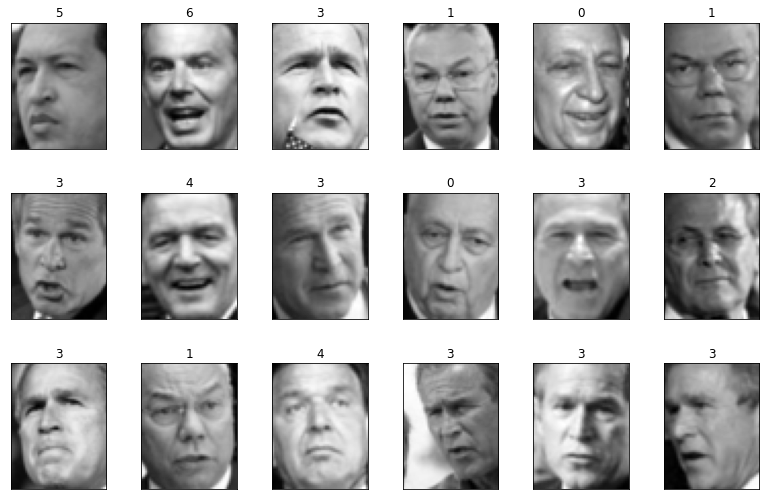

In [99]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
plot_gallery(X, list(y), h, w, n_row=3, n_col=6)

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Estadisticas de los datos:")
print(f"Numero de datos de entrenamiento: {X_train.shape[0]}")
print(f"Numero de datos de test: {X_test.shape[0]}")

Estadisticas de los datos:
Numero de datos de entrenamiento: 1030
Numero de datos de test: 258


In [101]:
# PCA
n_components = 150

print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)
print("Finalizado en %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("Finalizado en %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 1030 faces
Finalizado en 0.147s
Projecting the input data on the eigenfaces orthonormal basis
Finalizado en 0.000s


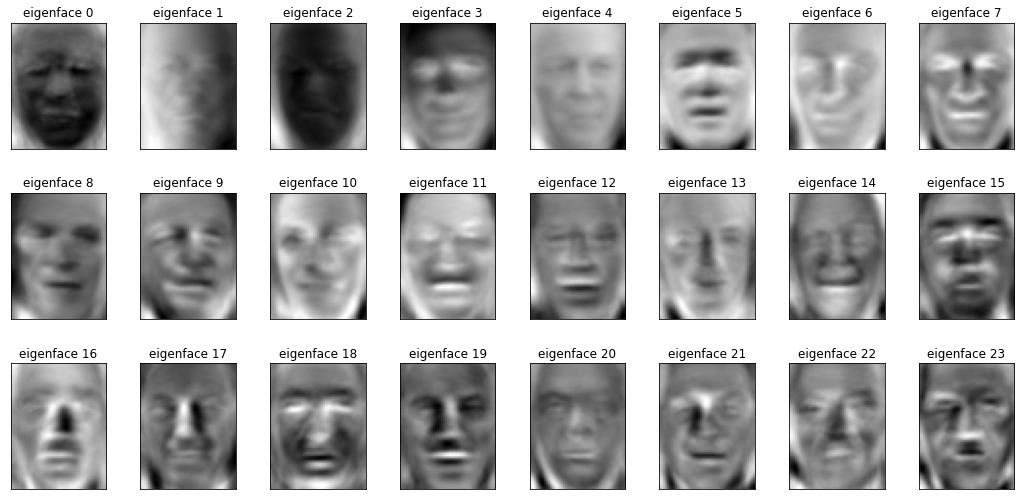

In [102]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w, n_row=3, n_col=8)
plt.show()

Predicting people's names on the test set
done in 0.000s
                   precision    recall  f1-score   support

     Ariel Sharon       0.62      0.73      0.67        11
     Colin Powell       0.78      0.89      0.83        47
  Donald Rumsfeld       0.74      0.77      0.76        22
    George W Bush       0.97      0.87      0.92       119
Gerhard Schroeder       0.71      0.89      0.79        19
      Hugo Chavez       0.80      0.62      0.70        13
       Tony Blair       0.79      0.81      0.80        27

         accuracy                           0.84       258
        macro avg       0.77      0.80      0.78       258
     weighted avg       0.85      0.84      0.84       258

[[  8   1   2   0   0   0   0]
 [  3  42   0   2   0   0   0]
 [  2   0  17   0   2   0   1]
 [  0   7   4 103   1   2   2]
 [  0   1   0   0  17   0   1]
 [  0   2   0   0   1   8   2]
 [  0   1   0   1   3   0  22]]


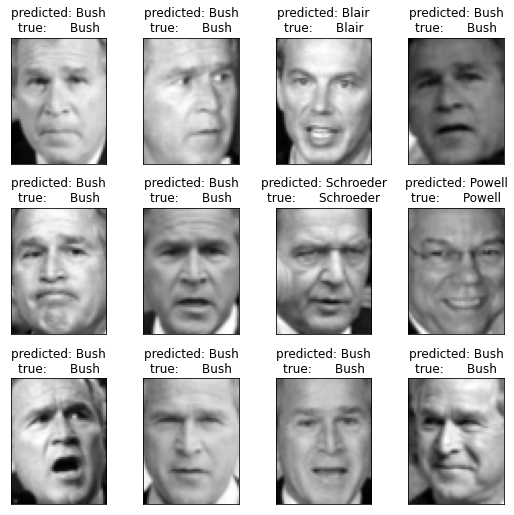

In [108]:
print("Predicting people's names on the test set")
t0 = time()
clf = ClassifEuclid(np.unique(y_train))
clf = clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)
prediction_titles = [title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, h, w)